In [11]:
import numpy as np
import matplotlib.pyplot as plt
import importlib.util
import sys
import os
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.collections import PathCollection

from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch

from scipy.optimize import curve_fit

module_name = "utils_v2"
file_path = "/workspaces/TP3/utils_v2.py"

spec = importlib.util.spec_from_file_location(module_name, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = module
spec.loader.exec_module(module)

# Importer le module
import utils_v2 as u

import pandas as pd

In [24]:
#import datas

N =48

#will contain arrays
Vs = []
ACVs = []

#will contain the discharge voltage and pressure for each file
discharge_Vs =[]
Ps = [] #pressure is in mbar


for i in range(1, N+1):
    # Load pressures from P.xlsx
    pressures_df = pd.read_excel('/workspaces/TP3/TP_Plasma/Datas/P.xlsx', usecols=[1,2], header=None)

    # Get the corresponding pressure for the current file
    pressure_value = pressures_df.iloc[i-1, 0]
    pressure_info = pressures_df.iloc[i-1, 1]
    
    if (isinstance(pressure_value, str) and pressure_value.lower() == "rien") or (isinstance(pressure_info, str) and pressure_info.lower() == "rien"):
        continue
    else :
        if i < 10:
            Air = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/AIR000{i}.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
        else:
            Air = pd.read_csv(f'/workspaces/TP3/TP_Plasma/Datas/AIR00{i}.CSV', sep=';', decimal='.', header=21, usecols=[0, 1])
        Air_V = Air.iloc[:,0].to_numpy()
        Air_ACVs = Air.iloc[:,1].to_numpy()
        
        #convert into volts
        Air_V = Air_V*1000
        
        Vs.append(Air_V)
        ACVs.append(Air_ACVs)
        
        
        #convert pressur_value to a float
        pressure_value = float(pressure_value)
        Ps.append(pressure_value)
    
        discharge_Vs.append(np.max(Air_V))
    
    
Ps = np.array(Ps)
discharge_Vs = np.array(discharge_Vs)

#voltage in V
Vs

dt = 0.401

print(Ps)




[0.031 0.031 0.033 0.035 0.037 0.038 0.041 0.04  0.044 0.046 0.05  0.053
 0.055 0.058 0.061 0.064 0.069 0.073 0.077 0.08  0.085 0.09  0.095 0.1
 0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55  0.6   0.66  0.7
 0.75  0.8   0.85  0.9  ]


/workspaces/TP3/utils_v2.py:346: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend(ncol = ncol, loc = loc)


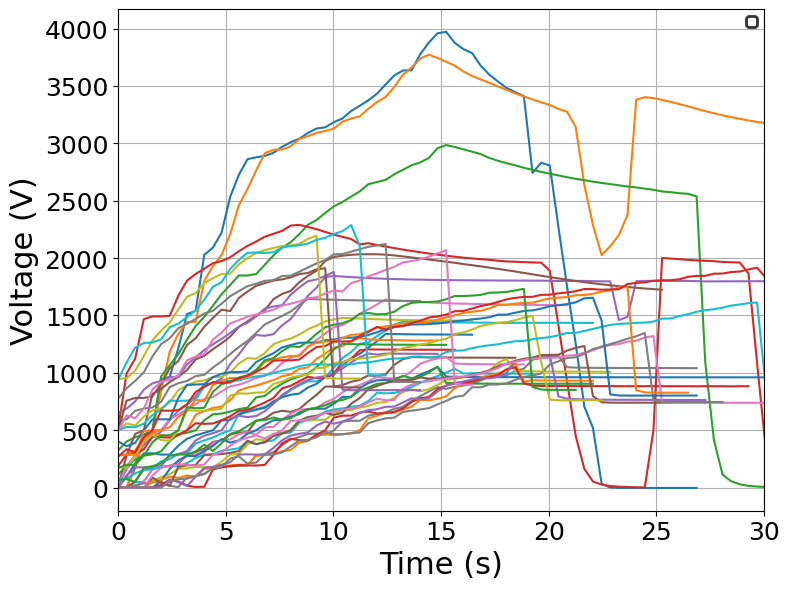

In [25]:
#plot
xlabel = "Time (s)"
ylabel = "Voltage (V)"


ax,fig = u.create_figure_and_apply_format((8,6),xlabel=xlabel, ylabel=ylabel)

# plot_array = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


for i in range(len(Vs)):
    
    V = np.array(Vs[i])
    t = np.linspace(0, (len(V) - 1) * dt, len(V))

    # ax.plot(t,V, label=f'P = {Ps[i-1]} mbar')
    ax.plot(t,V)
    
    ax.set_xlim(0, 30)


u.set_legend_properties(ax)
plt.show()




## Plot the Paschen curve


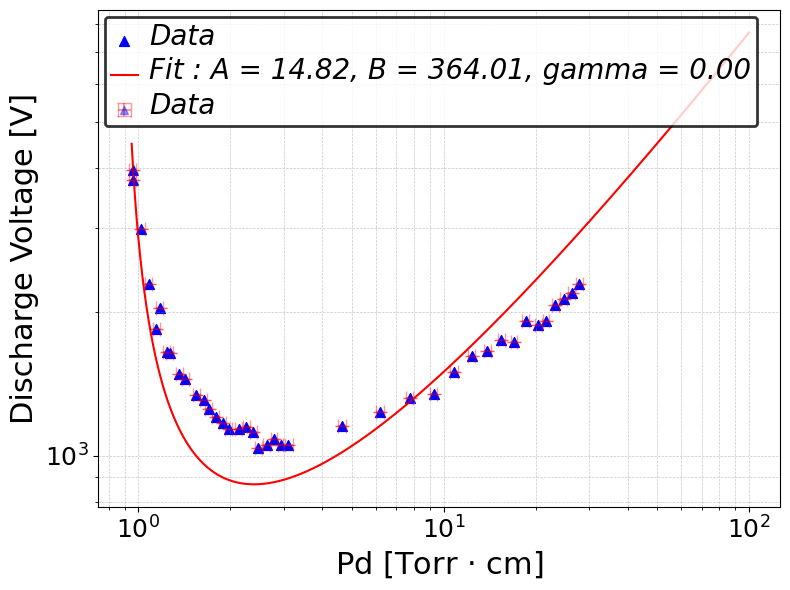

In [32]:
#in cm, 1cm of error
d = 41.2
d_error = 1

#now build the error on the pressure
#the error on the pressure is 0.1e-1 if the pressure is in e-1, 0.1e-2 if the pressure is in e-2,etc.add()
# Calculate the error on the pressure based on its magnitude
Ps_error = np.array([0.1 * 10 ** (np.floor(np.log10(p)) - 1) for p in Ps])

Ps_error_torr = Ps_error *0.75006

#P in Torr
Ps_torr = Ps*0.750062

#error on pd
pd_error = Ps_torr*d_error + Ps_error_torr*d



#define the function for the fit 
eps = 1e-9  # Petite valeur pour éviter log(0)
def fit(pd, A, B, gamma):
    log_term = np.log(A * pd)
    inner_log = np.log(1 + 1/gamma)
    
    if np.any(log_term - np.log(inner_log) <= 0):  # Empêcher division par zéro ou log négatif
        return np.inf
    
    return B * pd / (np.log(A * pd + eps) - np.log(np.log(1 + 1/gamma) + eps))




#plot all the datas except the first 6 values (too high discharge voltage)
ax,fig = u.create_figure_and_apply_format((8,6),xlabel=r"Pd [Torr $\cdot$ cm]", ylabel="Discharge Voltage [V]")

ax.scatter(Ps_torr*d, discharge_Vs, label='Data', color='blue',marker = '^',s=50)
ax.errorbar(Ps_torr*d, discharge_Vs, xerr=pd_error, yerr=0.1, fmt='^', label='Data', color='blue', ecolor='red', capsize=5, alpha=0.4)

#now make a fit 
popt, pcov = curve_fit(fit, Ps_torr*d, discharge_Vs, p0=[15,365,0.5],bounds = ([14,364,0], [16, 366, 0.6]))

#plot the fit
pd_fit = np.logspace(0,100,100000)
pd_fit = np.linspace(0.95, 100, 100000)
ax.plot(pd_fit, fit(pd_fit, *popt), label=f'Fit : A = {popt[0]:.2f}, B = {popt[1]:.2f}, gamma = {popt[2]:.2f}', color='red')

ax.set_xscale('log')
ax.set_yscale('log')

u.set_legend_properties(ax,loc="upper left")

plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

plt.show()


    
